# Optimization of spatial infraestructure for EV charging

## II. General formulation
$$ min \sum_{i,j} c_{ij} \Pi_{ij} $$

Subject to:

$$ \sum_{j} \Pi_{ij} = q_{i} $$
$$ \sum_{i} \Pi_{ij} = s_{i}$$

TyPical cost function:
$$C = (c_{ij})$$
Where c is a convex function, i.e.: the distance between station location and demand location in some norm:
$$c_{ij} = c(x_{i}, y_{j}) = |x_{i} - y_{j}|$$

In [199]:
#import Pkg;
#Pkg.add("Mosek")
#Pkg.build("Mosek")
#Pkg.add("MosekTools")
#Pkg.build("MosekTools")
#Pkg.add("Distributions")
#Pkg.add("StatsBase")
#Pkg.add("Gurobi")

    Updating registry at `C:\Users\Equipo\.julia\registries\General`
   Resolving package versions...
   Installed StatsBase ─ v0.33.14
    Updating `C:\Users\Equipo\Documents\GitHub\MATE\Project.toml`
  [2913bbd2] + StatsBase v0.33.14
    Updating `C:\Users\Equipo\Documents\GitHub\MATE\Manifest.toml`
  [2913bbd2] ↑ StatsBase v0.33.13 ⇒ v0.33.14
Precompiling project...
  ✓ StatsBase
  ✓ Distributions
  ✓ Plots
  3 dependencies successfully precompiled in 49 seconds (162 already precompiled, 2 skipped during auto due to previous errors)
  3 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions


General declarations and functions:

In [5]:
using Gurobi
using JuMP, GLPK, Mosek
using MosekTools
using VoronoiCells, GeometryBasics, Plots
using Random
using Statistics
using Distributions
using StatsBase

In [6]:
function get_cost_matrix(x, y, norm=2)    
    m = size(x)[1]
    n = size(y)[1]
    #Calculo los costos Cij = |xi-yj| (distancia euclidea en R^2)
    c1 = (x[:,1]*ones(1,n) - ones(m,1)*y[:,1]').^norm
    c2 = (x[:,2]*ones(1,n) - ones(m,1)*y[:,2]').^norm
    return (c1+c2).^(1/norm)
end

get_cost_matrix (generic function with 2 methods)

In [51]:
function plot_locations(x, title)
    
    gr()
    Plots.GRBackend()
    
    m = size(x)[1]
    
    X = x[:,1]
    Y = x[:,2]
    
    scatter(X, Y, aspect_ratio=:equal, alpha = 0.5, markersize = 1, xlim = (-0.1, 1.1), ylim = (-0.1, 1.1), title = title, legend = false)
    
end

plot_locations (generic function with 1 method)

In [46]:
function plot_stations(y, title)
   
    plot_locations(y, title)
    
    n = size(y)[1];
    
    points = [Point2(y[i,1], y[i,2]) for i in 1:n];
    
    scatter!(y[:,1], y[:,2], markersize = 6, label = "Stations", markershape = :star) # Plot Stations
    #annotate!([(points[i][1] + 0.02, points[i][2] + 0.03, text(i, :black)) for i in 1:n]) # Add Station Number
    
end

plot_stations (generic function with 1 method)

In [56]:
function plot_b_stations(y, b)
   
    #plot_locations(y, title)
    
    n = size(y)[1];
    
    points = [Point2(y[i,1], y[i,2]) for i in 1:n];
    
    scatter(y[:,1], y[:,2], markersize = 6, label = "Stations", markershape = :star) # Plot Stations
    #annotate!([(points[i][1] + 0.02, points[i][2] + 0.03, text(i, :black)) for i in 1:n]) # Add Station Number
    
end

plot_b_stations (generic function with 2 methods)

In [44]:
function plot_assignments(x, y, Pi, voronoi = true)
    gr()
    Plots.GRBackend()

    # Define m and n
    m = size(x)[1]
    n = size(y)[1]

    # Create Stations List
    points = [Point2(y[i,1], y[i,2]) for i in 1:n] 

    # Voronoi Cells
    rect = Rectangle(Point2(0, 0), Point2(1, 1))
    tess = voronoicells(points, rect);
        
    if voronoi == true
        plot(tess, color = :green, alpha = 0.4)
    end

    #Assigments
    assigned_index = [argmax(Pi[i,:]) for i in 1:m];
    
    #Array of arrays. Each array is the amount of cars that go on a particular station
    X = [ x[findall(x->x==i, assigned_index),1] for i in 1:n];
    Y = [ x[findall(x->x==i, assigned_index),2] for i in 1:n];

    for i = 1:n
        scatter!(X[i], Y[i], aspect_ratio=:equal, markersize = 3, legend = :topleft, labels = "Assigned to $i") # Plot EVs (differente color by each Station)
    end
        
    for i=1:m
        plot!([x[i,1],y[assigned_index[i],1]],[x[i,2],y[assigned_index[i],2]],color=:black, alpha = 0.2, labels = "") 
    end
    
    scatter!(y[:,1], y[:,2], markersize = 8, label = "Stations", markershape = :star, color=:white) # Plot Stations
    annotate!([(points[i][1] + 0.04, points[i][2] + 0.00, text(i, :black)) for i in 1:n]) # Add Station Number
end

plot_assignments (generic function with 2 methods)

In [145]:
m = 100; # Demand locations count
n = 5; # Station locations count
norm = 2; # Manhattan Metric

### Plot Ev distribution

In [15]:
function delete_row(matrix, row_index)
    
    return matrix[setdiff(1:end, row_index), :];
    
end

function random_points(size, dx, dy)
   
    rand_x = rand(dx, (size,1))
    rand_y = rand(dy, (size,1))
    
    random_point = hcat(rand_x, rand_y);
    
    return random_point;
    
end

function Geneterate_Ev_distribution(congestion_centers, seed = 42)
    
    Random.seed!(40)

    x = [0 0]
    
    for congestion_point in congestion_centers
    
        mean_x = congestion_point[1];
        mean_y = congestion_point[2];
        variance_x = congestion_point[3];
        variance_y = congestion_point[4];
        amount_of_evs = Int(m * (congestion_point[5] / 100));

        dx = Distributions.Normal(mean_x, variance_x)
        dy = Distributions.Normal(mean_y, variance_y)

        new_points = random_points(amount_of_evs, dx, dy)

        x = vcat(x, new_points)  

    end

    x = delete_row(x, 1);
    
    return sortslices(x, dims = 1);
    
end

Geneterate_Ev_distribution (generic function with 2 methods)

In [146]:
# (mu_x, mu_y, sigma for both, percentage cars)

congestion_centers = [(0.6, 0.5, 0.08, 0.15, 70), (0.4, 0.4, 0.13, 0.05, 30)];

x = Geneterate_Ev_distribution(congestion_centers);

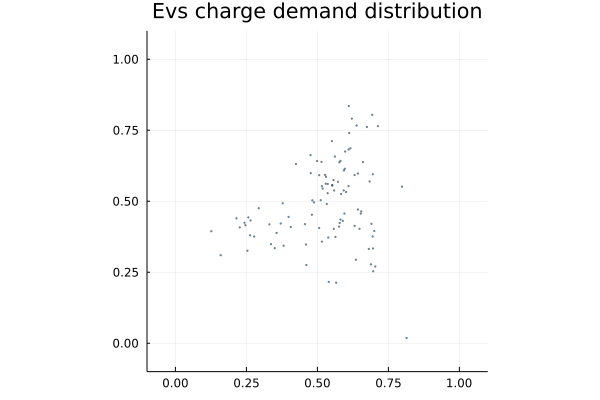

In [147]:
plot_locations(x, "Evs charge demand distribution")

### Plot stations locations

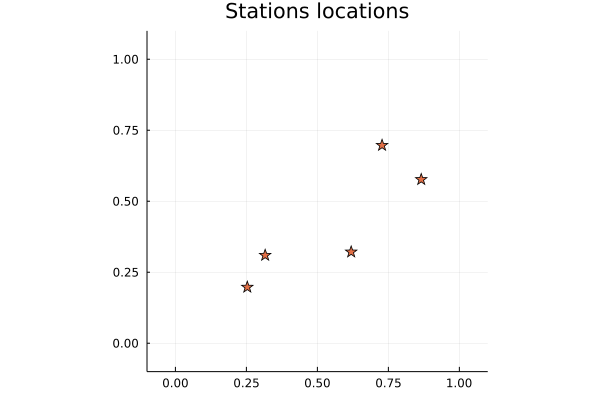

In [148]:
Random.seed!(24)

d = Distributions.Normal(0.5, 0.22)

y = sortslices(rand(d, (n,2)), dims = 1);

plot_stations(y, "Stations locations")

### Generar matriz de costo

In [149]:
C = get_cost_matrix(x, y, norm);
q = ones(m,1);

## III. Optmial transport for fixed locations
We assume that the station locations $\{ y_j \}$ have already been selected

### A. Free Capacities

We assume that the station locations $\{ y_j \}$ have already been selected, and their supply capacities can be arbitrarly chosen.

In [150]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m,1:n]>=0)

@constraint(model, sum(Pi, dims=2) .== q)

@objective(model,Min, sum( C.*Pi ))

#print(model)
model;

In [151]:
optimize!(model)

In [18]:
s = sum(value.(Pi), dims=1)'

5×1 adjoint(::Matrix{Float64}) with eltype Float64:
  1.0
 23.0
 37.0
 38.0
  1.0

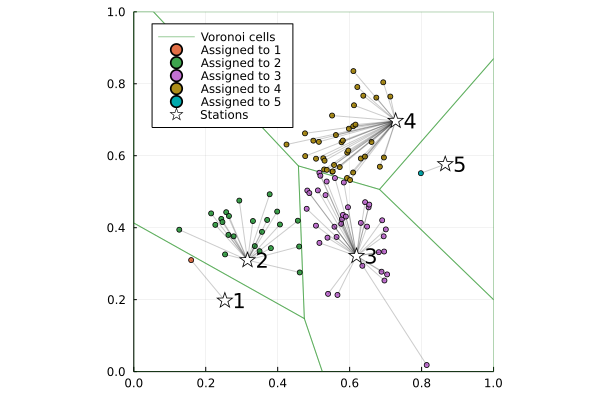

In [19]:
# Graficar la asignacion
Pi = value.(Pi) 
plot_assignments(x, y, Pi)

### B. Fixed Capacities

#### Simple discrete counterexample
$$C = \begin{bmatrix}
1 & 3\\
3 & 1
\end{bmatrix}$$

$$q = \begin{bmatrix}
1\\
2
\end{bmatrix}$$

$$s = \begin{bmatrix}
2 & 1
\end{bmatrix}$$

Then:

$$\Pi^{*} = \begin{bmatrix}
1 & 0\\
1 & 1
\end{bmatrix}$$

In [20]:
C1 = [1 3; 3 1]
q1 = [1; 2]
s = [2 1]


model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:2, 1:2] >=0 )
@constraint(model, sum(Pi, dims=2) .== q1)
@constraint(model, sum(Pi, dims=1) .== s )

@objective(model,Min, sum( C1.*Pi ))

#print(model)
model

optimize!(model)
value.(Pi)

2×2 Matrix{Float64}:
 1.0  0.0
 1.0  1.0

#### Proposition 1

Suppose:

* Más ubicaciones de demanda, que estaciones: $m \ge n$
* Demandas unitarias: $q_{i} = 1$, $i = 1, ..., m$
* Capacidad justa: $s_{j} \in Z, s_{j} > 0, \sum_{j} s_{j} = m$

Then: 

La solución óptima $\Pi^{*}$ debe ser de ceros y unos ($\Pi_{ij} \in \{ 0, 1\}$)


In [156]:
#Vector de capacidades
aux = rand(n,1); #random proportion for s
s = round.(aux/sum(aux)*m); #normalization
s[argmax(s)] += (m - sum(s)); #error correction
s

5×1 Matrix{Float64}:
  3.0
  7.0
 33.0
 36.0
 21.0

In [215]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m,1:n]>=0)

@constraint(model, sum(Pi, dims=2) .== q)
@constraint(model, sum(Pi, dims=1) .== 10*ones(n,1)' ) #FIXME: El s_max es el mismo en todas las estaciones (Ilustra mejor)

@objective(model,Min, sum( C.*Pi ))

#print(model)
model;

In [216]:
optimize!(model)
value.(Pi);

In [217]:
#[TODO] Find values not in 0 or 1 to verify
#find(value.(Pi) != 0 || value.(Pi) != 1);


[10.0 10.0 10.0 10.0 10.0]


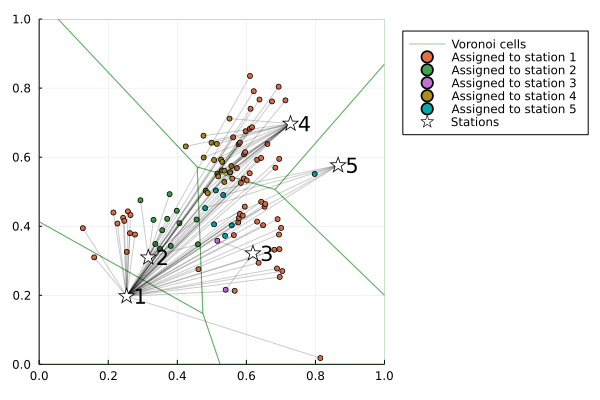

In [218]:
# Graficar la asignacion
Pi = value.(Pi) 

println(sum(Pi, dims = 1))

plot_assignments(x, y, Pi)

#### Case m = n

In [161]:
m2 = 10; # Demand locations count
n2 = 10; # Station locations count

x2 = sortslices(rand(m2,2), dims = 1);
y2 = sortslices(rand(n2,2), dims = 1);
C2 = get_cost_matrix(x2, y2, norm); #Matriz de costos
q2 = ones(m2,1);

#Vector de capacidades
s2 = ones(n2,1); 

In [162]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m2,1:n2]>=0)

@constraint(model, sum(Pi, dims=2) .== q2)
@constraint(model, sum(Pi, dims=1) .== s2' )

@objective(model,Min, sum( C2.*Pi ))

#print(model)
model;

In [163]:
optimize!(model)
value.(Pi);

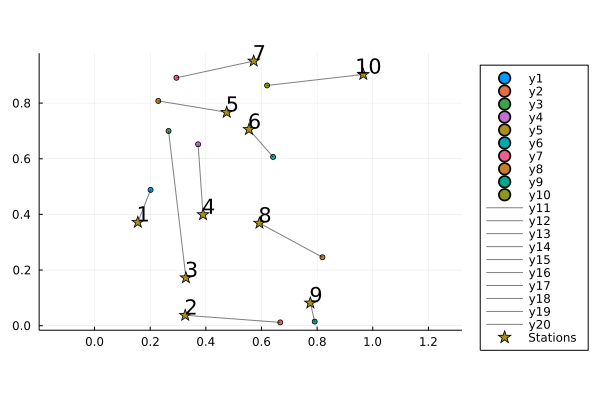

In [164]:
# Graficar la asignacion
Pi = value.(Pi) 
plot_assignments(x2, y2, Pi, false)

In [165]:
#Vector de capacidades
s = sum(value.(Pi), dims=1)'

10×1 adjoint(::Matrix{Float64}) with eltype Float64:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

### C. Constrained capacities

We assume that the station locations $\{ y_j \}$ have already been selected, and their supply capacities can be arbitrarly chosen.

#### Proposition 2

Suppose:

* Más ubicaciones de demanda, que estaciones: $m \ge n$
* Demandas unitarias: $q_{i} = 1$, $i = 1, ..., m$
* Capacidades topeadas (aseguran demanda): $\overline{s}_{j} \in Z, s_{j} > 0, \sum_{j} \overline{s}_{j} \ge m$

Then: 

La solución óptima $\Pi^{*}$ debe ser de ceros y unos ($\Pi_{ij} \in \{ 0, 1\}$)


In [166]:
#Vector de cotas de capacidad
#aux = rand(n,1); #random proportion for s
#tolerance = 0.2; 
#s_max = round.(aux/sum(aux)*m*(1+tolerance)) #normalization

In [167]:
#sum(s_max)

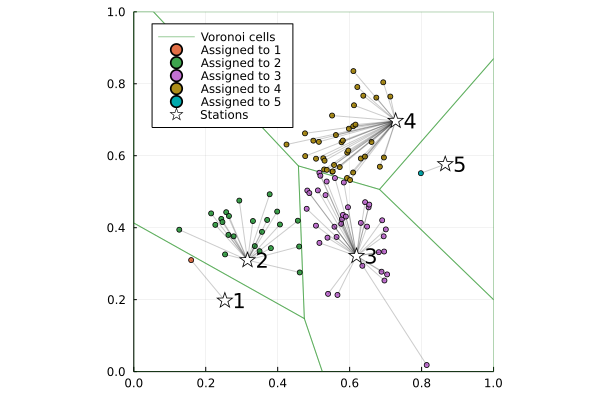

In [21]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m,1:n]>=0)

@constraint(model, sum(Pi, dims=2) .== q)

@objective(model,Min, sum( C.*Pi ))

optimize!(model)

Pi_free = value.(Pi); 

plot_assignments(x, y, Pi_free)

#savefig("Free_capacities.pdf")

In [22]:
function Difference_Assignation(x, Pi_old, Pi_new)
    
    n = size(Pi_old)[2]
    
    #Assigments
    assigned_index = [argmax(Pi[i,:]) for i in 1:m];
    
    #Array of arrays. Each array is the amount of cars that go on a particular station
    X = [ x[findall(x->x==i, assigned_index),1] for i in 1:n];
    Y = [ x[findall(x->x==i, assigned_index),2] for i in 1:n];

    
end

Difference_Assignation (generic function with 1 method)

[3.0 25.0 25.0 25.0 22.0][0.0 -0.06398666712954441 -0.11254157251429729 -0.09663448924923052 0.0]


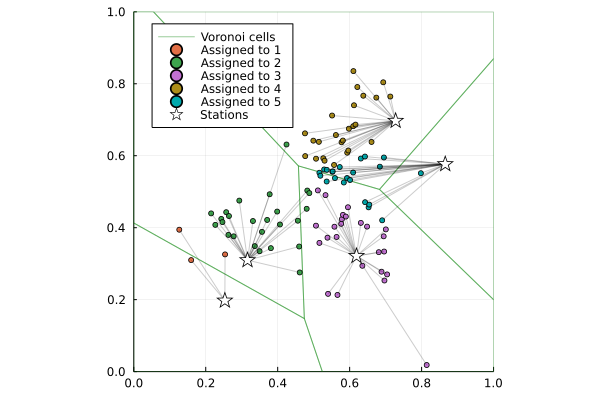

In [168]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m,1:n]>=0)

@constraint(model, sum(Pi, dims=2) .== q)
@constraint(model, con, sum(Pi, dims=1) .<= 25*ones(1, n)) 

@objective(model,Min, sum( C.*Pi ))

optimize!(model)

# Graficar la asignacion
Pi = value.(Pi) 
println(sum(Pi, dims=1), shadow_price.(con));

plot_assignments(x, y, Pi)

#savefig("Constrained_capacities.pdf")

#### Penalized capacities

Suppose, instead, that one is designing an installation with known locations but still has not defined the relevant capacities. Leaving them complete free may be undesirable, but one could seek to even out the allocation somewhat between locations.

With this aim, we consider a problem where a soft penalty term to the transport cost:

$$ min \sum_{ij} c_{ij} \Pi_{ij} + \epsilon \sum_{j} \phi_{j}(s_{j})$$

Subject to:

$$\sum_{j} \Pi_{ij} = q_{i}$$
$$\sum_{i} \Pi_{ij} = s_{j}$$

In this case, we use $\phi_{j}(s) = \frac{1}{2}s^{2}$

In [62]:
function phi(s)
    return 0.5*(s.^2)
end

phi (generic function with 1 method)

In [63]:
using Ipopt
epsilon = 0.5

model = JuMP.Model(Ipopt.Optimizer)

@variable(model, Pi[1:m,1:n]>=0)
@variable(model, s[1:n]>=0)

@constraint(model, sum(Pi, dims=2) .== q)
@constraint(model, sum(Pi, dims=1) .== s')

@objective(model,Min, sum( C.*Pi ) + epsilon*sum(phi(s)));


In [64]:
optimize!(model)
value.(Pi), objective_value(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2010
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1010
                     variables with only lower bounds:     1010
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equal

([3.0391052175946426e-8 1.0898089255285064e-8 … 0.0 0.0; 5.2088287601085356e-8 1.9720914588450148e-8 … 0.0 0.0; … ; 0.0 0.0 … 6.230460065890522e-8 0.9999998185432516; 0.0 0.0 … 4.846981502359233e-8 0.0], 10.463289362916125)

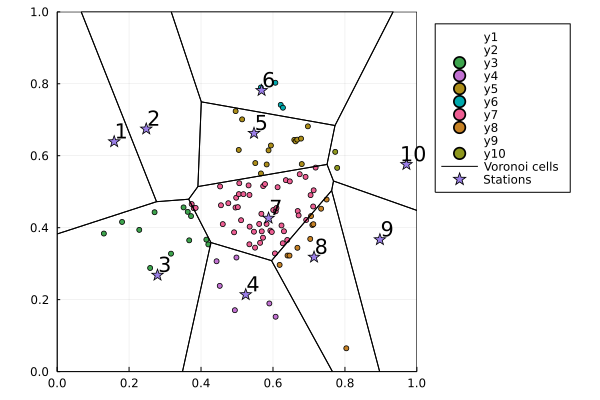

In [65]:
# Graficar la asignacion
Pi = value.(Pi) 
plot_assignments(x, y, Pi)

## IV. Location Selection
In this section we consider the situation where the location poitns are also part of the design.

### A. Free locations

[TODO] K - Means

### B. Sparse selection over a set of candidate locations

Example 1 - Verification

$$x = y = \begin{bmatrix}
1\\
2\\
5
\end{bmatrix}$$

Then:

$$C = \begin{bmatrix}
0 & 1 & 4\\
1 & 0 & 3\\
4 & 3 & 0
\end{bmatrix}$$

$$q = \begin{bmatrix}
2\\
3\\
1
\end{bmatrix}$$

$$\overline{s} = \begin{bmatrix}
s & s & s
\end{bmatrix}$$

Case 1: s = 5

In [39]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m,1:n]>=0)

@constraint(model, sum(Pi, dims=2) .== q)
@constraint(model, sum(Pi, dims=1) .<= s_max' )

@objective(model,Min, sum( C.*Pi ));

In [40]:
optimize!(model)
value.(Pi), objective_value(model);

Case 2: s = 4

### MILP (Mixed-integer linear programming)

$$min \sum_{ij} c_{ij} \Pi_{ij}$$

Subject to:

$$\sum_{j} \Pi_{ij} = q_i$$
$$\sum_{i} \Pi_{ij} \le b_{j}\overline{s}_{j}$$
$$\sum_{j} b_{j} \le k$$
$$b_{j} \in \{ 0, 1\}$$

Where: 

$b_{j}$ indicates whether station $y_{j}$ is active or not

$k$ is the count of active actions

In [114]:
k = 4
q = 1*ones(m,1)
s_max = 250*1.2*ones(n,1);
# Validar que la cantidad de prendidos, con la capacidad q, den para cubrir todos los EVs

In [115]:
model = JuMP.Model(Mosek.Optimizer)
#model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m,1:n]>=0)
@variable(model, b[1:n], Bin)

@constraint(model, sum(Pi, dims=2).== q)
@constraint(model, sum(Pi, dims=1)' .<= (b.*s_max) )
@constraint(model, sum(b) <= k)

@objective(model,Min, sum( C.*Pi ));

In [116]:
optimize!(model)
objective_value(model)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 1101            
  Cones                  : 0               
  Scalar variables       : 100100          
  Matrix variables       : 0               
  Integer variables      : 100             

Optimizer started.
Mixed integer optimizer started.
Threads used: 4
Presolve started.
Presolve terminated. Time = 1.64
Presolved problem: 100100 variables, 1101 constraints, 200200 non-zeros
Presolved problem: 0 general integer, 100 binary, 100000 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   4.4725391593e+01     NA          2.3   
0        1        1        0        1.2062009292e+02     4.4725391593e+01     62.92       6.4   
Cut generation started.
0        1        1        0

LoadError: InterruptException:

In [121]:
function plot_assignments_2(x, y, Pi, b)
    gr()
    Plots.GRBackend()

    # Define m and n
    m = size(x)[1]
    n = size(y)[1]

    k = Int(round(sum(b)));
    
    #Points of availabile stations
    points = [Point2(y[i,1], y[i,2]) for i in 1:n]
    
    not_available_stations_index = findall(x -> x <= 0.5, b)
   
    deleteat!(points, not_available_stations_index)


    # Voronoi Cells
    rect = Rectangle(Point2(0, 0), Point2(1, 1))
    tess = voronoicells(points, rect);

    #Assigments
    assigned_index = [argmax(Pi[i,:]) for i in 1:m];
    
    #Array of arrays. Each array is the amount of cars that go on a particular station
    X = [ x[findall(x->x==i, assigned_index),1] for i in 1:n];
    Y = [ x[findall(x->x==i, assigned_index),2] for i in 1:n];

    
    #Plot cars locations
    scatter(X, Y, aspect_ratio=:equal, markersize = 3, legend = :outertopright ) # Plot EVs (differente color by each Station)
    
    #Plot voronoi lines
    plot!(tess, color = :black, alpha = 0.2)
    
 
    #Plot available stations locations
    available_stations_positions = y;
    
    available_stations_positions = delete_row(available_stations_positions, not_available_stations_index)
      
    scatter!(available_stations_positions[:,1], available_stations_positions[:,2], markersize = 6, label = "Stations", markershape = :star) # Plot Stations
    
    
    #Plot available stations number text
    available_stations_index = findall(x -> x > 0.5, b)
    
    annotate!([(points[i][1] + 0.02, points[i][2] + 0.03, text(available_stations_index[i], :black)) for i in 1:k]) # Add Station Number
end

plot_assignments_2 (generic function with 1 method)

In [117]:
# Graficar la asignacion
Pi = value.(Pi) 
b = value.(b)



#plot_assignments_2(x, y, Pi, b)

LoadError: OptimizeNotCalled()

In [81]:
s = sum(round.(value.(Pi)), dims=1)'

5×1 adjoint(::Matrix{Float64}) with eltype Float64:
  0.0
 30.0
 30.0
 30.0
 10.0

In [118]:
function Solve_MILP(k, C)

    m = size(C)[1];
    n = size(C)[2];

    q = 1.0 * ones(m,1);
    
    #tolerance = 20;
    
    #s_max = (m / k) * (1 + tolerance / 100) * ones(n,1);
    s_max = 280 * ones(n,1);

    model = JuMP.Model(Gurobi.Optimizer);

    @variable(model,Pi[1:m,1:n] >= 0)
    @variable(model, b[1:n], Bin)

    @constraint(model, sum(Pi, dims=2).== q)
    @constraint(model, sum(Pi, dims=1)' .<= (b.*s_max) )
    @constraint(model, sum(b) <= k)

    @objective(model, Min, sum( C.*Pi ));

    optimize!(model);

    return objective_value(model);
    
end

function Solve_MILP_return_b(k, C)

    m = size(C)[1];
    n = size(C)[2];

    q = 1.0 * ones(m,1);
    
    #tolerance = 20;
    
    #s_max = (m / k) * (1 + tolerance / 100) * ones(n,1);
    s_max = 280 * ones(n,1);

    model = JuMP.Model(Gurobi.Optimizer);

    @variable(model,Pi[1:m,1:n] >= 0)
    @variable(model, b[1:n], Bin)

    @constraint(model, sum(Pi, dims=2).== q)
    @constraint(model, sum(Pi, dims=1)' .<= (b.*s_max) )
    @constraint(model, sum(b) <= k)

    @objective(model, Min, sum( C.*Pi ));

    optimize!(model);

    return value.(b);
    
end



Solve_MILP_return_b (generic function with 1 method)

In [22]:
function Create_random_b(k, n)
    
    b = zeros(n);

    random_availabile_stations = sample(1:n, k, replace=false)

    for i in 1:k
       b[random_availabile_stations[i]] = 1;
    end
    
    return b;
end


function Solve_MILP_random_b(k, C)

    m = size(C)[1];
    n = size(C)[2];
    
    q = 1.0 * ones(m,1);
    
    s_max = 280 * ones(n,1);
    
    #max_available_stations = 10;
    
    b = Create_random_b(k, n);

    #model = JuMP.Model(() -> Gurobi.Optimizer(GUROBI_ENV));
    #set_optimizer_attribute(model, "OutputFlag", 0)
    model = JuMP.Model(Gurobi.Optimizer);
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    @variable(model,Pi[1:m,1:n] >= 0)
    
    @constraint(model, sum(Pi, dims=2).== q)
    @constraint(model, sum(Pi, dims=1)' .<= (b.*s_max) )
    @constraint(model, sum(b) <= k)

    @objective(model, Min, sum( C.*Pi ));

    optimize!(model);

    return objective_value(model);
    
end

Solve_MILP_random_b (generic function with 1 method)

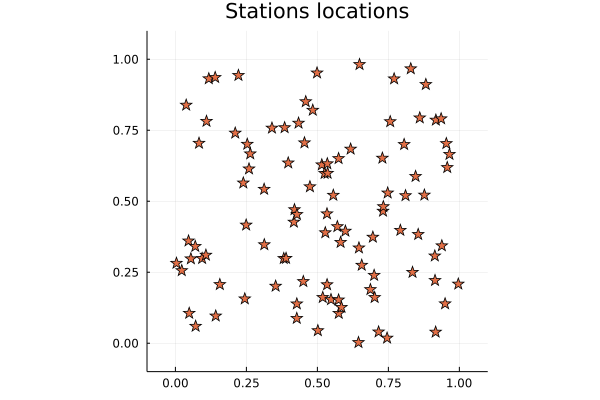

In [184]:
m = 1000; # Demand locations count
n = 100; # Station locations count
norm = 2; # Manhattan Metric

congestion_centers = [(0.6, 0.5, 0.08, 0.15, 70), (0.4, 0.4, 0.13, 0.05, 30)];

x = Geneterate_Ev_distribution(congestion_centers);

Random.seed!(9)

d = Distributions.Normal(0.5,0.25)

y = sortslices(rand(d, (n,2)), dims = 1);
y = sortslices(rand(n,2), dims = 1);

C = get_cost_matrix(x, y, norm);
q = ones(m,1);

plot_stations(y, "Stations locations")

In [203]:
function plot_b_stations(y, b, x)
   
    #plot_locations(y, title)
    
    X = x[:,1]
    Y = x[:,2]
    
    scatter(X, Y, aspect_ratio=:equal, alpha = 0.5, markersize = 2, xlim = (-0.1, 1.1), ylim = (-0.1, 1.1), legend = false)
    
    n = size(y)[1];
    
    points = [Point2(y[i,1], y[i,2]) for i in 1:n];
    
    
    choosen_points = copy(points);
    
    not_available_stations_index = findall(x -> x <= 0.5, b);
    
    deleteat!(choosen_points, not_available_stations_index);
    
    
    not_choosen_points = copy(points);
    
    available_stations_index = findall(x -> x > 0.5, b);
   
    deleteat!(not_choosen_points, available_stations_index);
    
    
    println(size(not_choosen_points), size(choosen_points))
    
    scatter!(choosen_points, markersize = 10, color = :yellow, markershape = :star)
    scatter!(not_choosen_points, color =:white, alpha = 0.4)
    
    #scatter(y[:,1], y[:,2], markersize = 6, label = "Stations", markershape = :star) # Plot Stations
    #annotate!([(points[i][1] + 0.02, points[i][2] + 0.03, text(i, :black)) for i in 1:n]) # Add Station Number
    
end

function plot_locations_2(x)
    
    #gr()
    #Plots.GRBackend()
    
    m = size(x)[1]
    
    X = x[:,1]
    Y = x[:,2]
    
    scatter!(X, Y, aspect_ratio=:equal, alpha = 0.5, markersize = 1, xlim = (-0.1, 1.1), ylim = (-0.1, 1.1), legend = false)
end

plot_locations_2 (generic function with 1 method)

In [185]:
k = 4;
m = 1000;

congestion_centers = [(0.6, 0.5, 0.08, 0.15, 70), (0.4, 0.4, 0.13, 0.05, 30)];

x = Geneterate_Ev_distribution(congestion_centers);

C = get_cost_matrix(x, y, norm);
q = ones(m,1);

b = Solve_MILP_return_b(k, C);



Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1101 rows, 100100 columns and 200200 nonzeros
Model fingerprint: 0x136d1f65
Variable types: 100000 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [2e-03, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 419.0529416
Presolve time: 0.22s
Presolved: 1101 rows, 100100 columns, 200200 nonzeros
Variable types: 100000 continuous, 100 integer (100 binary)

Root relaxation: objective 4.472539e+01, 54 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   44.72539    0   54  41

In [205]:
plot_b_stations(y, b, x)
savefig("Choosen_stations.pdf")

(96,)(4,)


(96,)(4,)


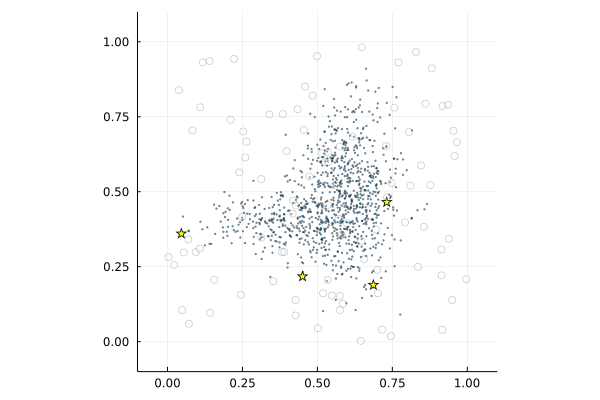

In [119]:
k = 4;
b = Create_random_b(k, n)

congestion_centers = [(0.6, 0.5, 0.08, 0.15, 70), (0.4, 0.4, 0.13, 0.05, 30)];

x = Geneterate_Ev_distribution(congestion_centers);




plot_b_stations(y, b, x)

In [134]:
max_k = 10;

cost_per_k = zeros(max_k - 3);

for k in 4:max_k
    cost = Solve_MILP(k, C);
    println("Cost [$k]: $cost");
    cost_per_k[k - 3] = cost;
end

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1101 rows, 100100 columns and 200200 nonzeros
Model fingerprint: 0x136d1f65
Variable types: 100000 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [2e-03, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 419.0529416
Presolve time: 0.20s
Presolved: 1101 rows, 100100 columns, 200200 nonzeros
Variable types: 100000 continuous, 100 integer (100 binary)

Root relaxation: objective 4.472539e+01, 54 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   44.72539    0   54  41

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1101 rows, 100100 columns and 200200 nonzeros
Model fingerprint: 0xf94c7da9
Variable types: 100000 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [2e-03, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 445.6330212
Presolve time: 0.20s
Presolved: 1101 rows, 100100 columns, 200200 nonzeros
Variable types: 100000 continuous, 100 integer (100 binary)

Root relaxation: objective 4.472539e+01, 54 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   44.72539    0   52  44

Cost [7]: 72.49890597347787
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1101 rows, 100100 columns and 200200 nonzeros
Model fingerprint: 0x41cdf10d
Variable types: 100000 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [2e-03, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+00]
Found heuristic solution: objective 468.8587081
Presolve time: 0.19s
Presolved: 1101 rows, 100100 columns, 200200 nonzeros
Variable types: 100000 continuous, 100 integer (100 binary)

Root relaxation: objective 4.472539e+01, 54 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0   

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1101 rows, 100100 columns and 200200 nonzeros
Model fingerprint: 0x2e568157
Variable types: 100000 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [2e-03, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 374.2805195
Presolve time: 0.22s
Presolved: 1101 rows, 100100 columns, 200200 nonzeros
Variable types: 100000 continuous, 100 integer (100 binary)

Root relaxation: objective 4.472539e+01, 54 iterations, 0.03 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   44.72539    0   48  37

### Cost per station available

In [177]:
ks = [4:max_k];

scatter(ks, cost_per_k, xaxis = "Number of active stations", yaxis = "Transport Cost", legend = false)
savefig("cost_per_k_2.pdf")

### Marginal cost for adding a station

In [180]:
marginal_cost = abs.(diff(cost_per_k));

marginal_cost_percentage = 100 * (marginal_cost ./ cost_per_k[1: max_k - 4]);

ks = [4:max_k-1];

scatter(ks, marginal_cost_percentage, xaxis = "Active stations", markersize = 6, yaxis = "Marginal cost (%)", legend = false, ylim = (0,15))
# bar(ks, marginal_cost_percentage, xaxis = "Number of available stations", yaxis = "Marginal cost (%)", title = "Decrease in cost for adding an extra station", legend = false)
savefig("marginal_cost_notitle_2.pdf")

In [138]:
#const GRB_ENV = Gurobi.Env()
max_k = 10;

cost_per_k_random_allocation = zeros(max_k - 3);

random_iterations = 40;

for k in 4:max_k
    #Get average of x samples
    average_cost = 0;
    
    for i = 1:random_iterations
        cost = Solve_MILP_random_b(k, C);
        average_cost = average_cost + cost;
        println("k: $k | iteration: $i/$random_iterations")
    end
    
    average_cost = average_cost / random_iterations;
        
    println("Cost [K: $k]: $average_cost");
        
    cost_per_k_random_allocation[k - 3] = average_cost;
end

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 4 | iteration: 1/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 4 | iteration: 2/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 4 | iteration: 3/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 4 | iteration: 4/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 4 | iteration: 5/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 4 | iteration: 6/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 4 | iteration: 7/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 4 | iteration: 8/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-

k: 5 | iteration: 32/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 5 | iteration: 33/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 5 | iteration: 34/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 5 | iteration: 35/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 5 | iteration: 36/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 5 | iteration: 37/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 5 | iteration: 38/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 5 | iteration: 39/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 5 | iteration: 40/40
Cost [K: 5]: 222.5632670834851
Set parameter Username
Ac

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 7 | iteration: 24/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 7 | iteration: 25/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 7 | iteration: 26/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 7 | iteration: 27/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 7 | iteration: 28/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 7 | iteration: 29/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 7 | iteration: 30/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 7 | iteration: 31/40
Set parameter Username
Academic license - for non-commercial use only - expires 

k: 9 | iteration: 14/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 9 | iteration: 15/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 9 | iteration: 16/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 9 | iteration: 17/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 9 | iteration: 18/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 9 | iteration: 19/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 9 | iteration: 20/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 9 | iteration: 21/40
Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-27
k: 9 | iteration: 22/40
Set parameter Username
Academic license - for non-commer

In [215]:
ks = [4:max_k];

# bar(ks, cost_per_k_random_allocation, labels = "Random allocation")
# bar!(ks, cost_per_k, labels = "Optimized allocation")

plot(ks, cost_per_k_random_allocation, markershape = :circle, labels = "Random allocation", ylim = (0,270))
plot!(ks, cost_per_k, markershape = :square, labels = "Optimized allocation")


xlabel!("Active Stations")
ylabel!("Cost")

savefig("random_vs_optimized.pdf")

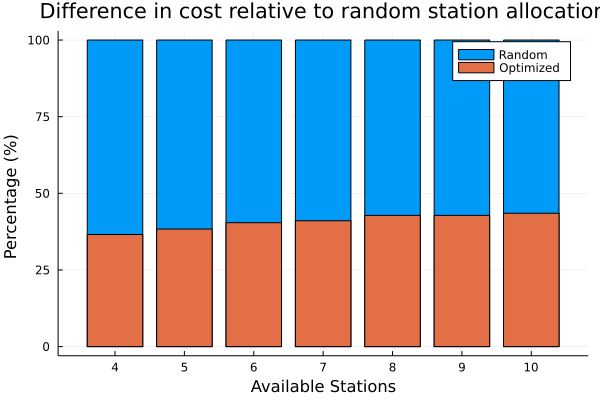

In [141]:
optimized_random_ratio = 100.0 * (cost_per_k ./ cost_per_k_random_allocation)



bar(ks, 100.0 * ones(size(optimized_random_ratio)), labels= "Random" )
bar!(ks, optimized_random_ratio, labels = "Optimized", title = "Difference in cost relative to random station allocation")


xlabel!("Available Stations")
ylabel!("Percentage (%) ")

#savefig("random_vs_optimized_normalized.pdf")